# Dimensional Aspect-Based Sentiment Analysis (DimABSA)
## SemEval-2026 Task 3, Subtask 1

**Authors**: Anıl Dervişoğlu, Ömer Faruk Zeybek  
**Course**: Deep Learning, Istanbul Technical University

---

### Experiments
1. **Baselines** (5 models × 2 domains):
   - Lexicon-Only (no neural network)
   - BERT-base
   - RoBERTa-base
   - Simplified DeBERTa (CLS pooling, no attention)
   - Full DeBERTa-DimABSA (attention + lexicon)

2. **Ablation Studies** (on restaurant):
   - Output scaling: sigmoid, tanh, linear
   - Loss functions: MSE, Huber, MAE
   - Learning rates: 1e-5, 2e-5, 5e-5

### Setup
1. Upload `DimABSA2026/` and `NRC-VAD-Lexicon-v2.1/` to Google Drive under `MyDrive/DL_Project/`

## 1. Setup

In [ ]:
# Install dependencies
!pip install -q transformers datasets accelerate
!pip install -q sentencepiece protobuf tiktoken

import torch
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("WARNING: No GPU! Go to Runtime > Change runtime type > T4 GPU")

PyTorch: 2.9.0+cu126
CUDA: True
GPU: NVIDIA A100-SXM4-80GB


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path

# ========== CONFIGURE YOUR PATHS ==========
DRIVE_PATH = '/content/drive/MyDrive/DL_Project'
# ==========================================

DATA_DIR = Path(DRIVE_PATH) / 'DimABSA2026' / 'task-dataset' / 'track_a' / 'subtask_1'
LEXICON_DIR = Path(DRIVE_PATH) / 'NRC-VAD-Lexicon-v2.1'
OUTPUT_DIR = Path(DRIVE_PATH) / 'outputs'

OUTPUT_DIR.mkdir(exist_ok=True)
(OUTPUT_DIR / 'checkpoints').mkdir(exist_ok=True)
(OUTPUT_DIR / 'submissions').mkdir(exist_ok=True)

print(f"Data: {DATA_DIR.exists()}")
print(f"Lexicon: {LEXICON_DIR.exists()}")

if not DATA_DIR.exists():
    print(f"\nERROR: Data not found! Upload DimABSA2026/ to {DRIVE_PATH}")

Mounted at /content/drive
Data: True
Lexicon: True


In [ ]:
# Imports
import json
import math
import re
import warnings
import time
from pathlib import Path
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModel

warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## 2. Configuration

In [ ]:
# ========== HYPERPARAMETERS ==========
@dataclass
class Config:
    # Models
    deberta_name: str = 'microsoft/deberta-v3-base'
    bert_name: str = 'bert-base-uncased'
    roberta_name: str = 'roberta-base'

    # Training
    batch_size: int = 16
    max_length: int = 128
    learning_rate: float = 2e-5
    num_epochs: int = 10
    patience: int = 3

    # Domains
    domains: tuple = ('restaurant', 'laptop')

cfg = Config()
print(f"Epochs: {cfg.num_epochs}")
print(f"Domains: {cfg.domains}")
print(f"Batch size: {cfg.batch_size}")
print(f"Learning rate: {cfg.learning_rate}")

Epochs: 10
Domains: ('restaurant', 'laptop')
Batch size: 16
Learning rate: 2e-05


## 3. Data Loading

In [ ]:
def load_jsonl(path):
    """Load JSONL file."""
    data = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                data.append(json.loads(line))
    return data

def parse_va(s):
    """Parse VA string like '7.5#6.2' into floats."""
    v, a = s.split('#')
    return float(v), float(a)

def to_dataframe(data):
    """Convert JSONL data to DataFrame with one row per aspect."""
    rows = []
    for e in data:
        tid, txt = e.get('ID', ''), e.get('Text', '')
        if 'Quadruplet' in e:
            for q in e['Quadruplet']:
                v, a = parse_va(q.get('VA', '5#5'))
                rows.append({'ID': tid, 'Text': txt, 'Aspect': q.get('Aspect', ''), 'Valence': v, 'Arousal': a})
        elif 'Triplet' in e:
            for t in e['Triplet']:
                v, a = parse_va(t.get('VA', '5#5'))
                rows.append({'ID': tid, 'Text': txt, 'Aspect': t.get('Aspect', ''), 'Valence': v, 'Arousal': a})
        elif 'Aspect_VA' in e:
            for x in e['Aspect_VA']:
                v, a = parse_va(x.get('VA', '5#5'))
                rows.append({'ID': tid, 'Text': txt, 'Aspect': x.get('Aspect', ''), 'Valence': v, 'Arousal': a})
    return pd.DataFrame(rows).drop_duplicates(subset=['ID', 'Aspect'])

def load_train_data(data_dir, domain, dev_size=0.1):
    """Load training data and split into train/dev."""
    lang_dir = Path(data_dir) / 'eng'
    train_file = lang_dir / f'eng_{domain}_train_alltasks.jsonl'
    df = to_dataframe(load_jsonl(train_file))
    train_df, dev_df = train_test_split(df, test_size=dev_size, random_state=42)
    return train_df.reset_index(drop=True), dev_df.reset_index(drop=True)

def load_test_data(data_dir, domain):
    """Load test data (dev_task1 files - no labels)."""
    lang_dir = Path(data_dir) / 'eng'
    test_file = lang_dir / f'eng_{domain}_dev_task1.jsonl'
    return load_jsonl(test_file)

# Load all data
data = {}
for domain in cfg.domains:
    train_df, dev_df = load_train_data(DATA_DIR, domain)
    test_data = load_test_data(DATA_DIR, domain)
    data[domain] = {'train': train_df, 'dev': dev_df, 'test': test_data}
    print(f"{domain.upper()}: train={len(train_df)}, dev={len(dev_df)}, test={len(test_data)}")

RESTAURANT: train=2796, dev=311, test=200
LAPTOP: train=4462, dev=496, test=200


## 4. NRC VAD Lexicon

In [ ]:
class NRCLexicon:
    """NRC VAD Lexicon for extracting sentiment features."""

    def __init__(self, path, window=5):
        self.window = window
        self.lex = {}
        with open(path, 'r', encoding='utf-8') as f:
            f.readline()  # Skip header
            for line in f:
                p = line.strip().split('\t')
                if len(p) >= 4:
                    # Convert [-1,1] to [1,9]: new = 4*old + 5
                    self.lex[p[0].lower()] = (4*float(p[1])+5, 4*float(p[2])+5)
        print(f"Lexicon: {len(self.lex):,} terms")

    def get_va(self, w):
        return self.lex.get(w.lower().strip())

    def extract(self, text, aspect):
        """Extract 8-dim feature vector."""
        tokens = re.sub(r'[^\w\s]', ' ', text.lower()).split()
        asp_tok = set(re.sub(r'[^\w\s]', ' ', aspect.lower()).split())
        asp_pos = [i for i, t in enumerate(tokens) if t in asp_tok] or list(range(len(tokens)))

        ctx_v, ctx_a, wts = [], [], []
        for i, t in enumerate(tokens):
            if t in asp_tok:
                continue
            va = self.get_va(t)
            if va:
                d = min(abs(i-p) for p in asp_pos)
                if d <= self.window:
                    ctx_v.append(va[0])
                    ctx_a.append(va[1])
                    wts.append(1/(1+d))

        asp_v = [self.get_va(t)[0] for t in asp_tok if self.get_va(t)]
        asp_a = [self.get_va(t)[1] for t in asp_tok if self.get_va(t)]

        f = [5.0]*8  # Neutral default
        if ctx_v:
            f[0], f[1] = np.mean(ctx_v), np.mean(ctx_a)
            tw = sum(wts)
            f[4] = sum(v*w for v,w in zip(ctx_v,wts))/tw
            f[5] = sum(a*w for a,w in zip(ctx_a,wts))/tw
            f[6], f[7] = max(ctx_v), max(ctx_a)
        if asp_v:
            f[2], f[3] = np.mean(asp_v), np.mean(asp_a)
        return torch.tensor(f, dtype=torch.float32)

    def extract_batch(self, texts, aspects):
        return torch.stack([self.extract(t, a) for t, a in zip(texts, aspects)])

    def predict(self, text, aspect, ctx_weight=0.3, asp_weight=0.7):
        """Lexicon-only prediction (baseline)."""
        f = self.extract(text, aspect)
        # Blend weighted context and aspect scores
        v = ctx_weight * f[4].item() + asp_weight * f[2].item()
        a = ctx_weight * f[5].item() + asp_weight * f[3].item()
        return max(1.0, min(9.0, v)), max(1.0, min(9.0, a))

# Load lexicon
lex_path = LEXICON_DIR / 'NRC-VAD-Lexicon-v2.1.txt'
lexicon = NRCLexicon(lex_path) if lex_path.exists() else None
if not lexicon:
    print("WARNING: Lexicon not found!")

Lexicon: 54,801 terms


## 5. Dataset & DataLoader

In [ ]:
class ABSADataset(Dataset):
    """Dataset for ABSA with aspect masking."""

    def __init__(self, df, tokenizer, max_len=128):
        self.df = df.reset_index(drop=True)
        self.tok = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        r = self.df.iloc[i]
        enc = self.tok(r['Text'], r['Aspect'], truncation=True, padding='max_length',
                       max_length=self.max_len, return_tensors='pt')
        item = {k: v.squeeze(0) for k, v in enc.items()}

        # Aspect mask
        if 'token_type_ids' in item:
            item['aspect_mask'] = (item['token_type_ids'] == 1).float()
        else:
            ids = item['input_ids']
            sep = (ids == self.tok.sep_token_id).nonzero(as_tuple=True)[0]
            mask = torch.zeros_like(ids, dtype=torch.float)
            if len(sep) >= 2:
                mask[sep[0]+1:sep[1]] = 1
            item['aspect_mask'] = mask

        item['labels'] = torch.tensor([r['Valence'], r['Arousal']], dtype=torch.float)
        item['text'], item['aspect'] = r['Text'], r['Aspect']
        return item

def collate_fn(batch):
    """Custom collate function."""
    out = {}
    for k in batch[0]:
        if isinstance(batch[0][k], torch.Tensor):
            out[k] = torch.stack([b[k] for b in batch])
        else:
            out[k] = [b[k] for b in batch]
    return out

def create_loaders(train_df, dev_df, tokenizer, batch_size=16, max_len=128):
    """Create train and dev dataloaders."""
    train_ds = ABSADataset(train_df, tokenizer, max_len)
    dev_ds = ABSADataset(dev_df, tokenizer, max_len)
    train_ld = DataLoader(train_ds, batch_size, shuffle=True, collate_fn=collate_fn)
    dev_ld = DataLoader(dev_ds, batch_size, shuffle=False, collate_fn=collate_fn)
    return train_ld, dev_ld

## 6. Model Definitions

In [ ]:
# ==================== BASELINE 1: BERT ====================
class BERTBaseline(nn.Module):
    """BERT-base with CLS pooling."""

    def __init__(self, model_name='bert-base-uncased', h=256, d=0.1, scaling='sigmoid'):
        super().__init__()
        self.enc = AutoModel.from_pretrained(model_name)
        hid = self.enc.config.hidden_size
        self.scaling = scaling
        self.v = nn.Sequential(nn.Linear(hid, h), nn.GELU(), nn.Dropout(d), nn.Linear(h, 1))
        self.a = nn.Sequential(nn.Linear(hid, h), nn.GELU(), nn.Dropout(d), nn.Linear(h, 1))

    def _scale(self, x):
        if self.scaling == 'sigmoid':
            return 1 + 8 * torch.sigmoid(x)
        elif self.scaling == 'tanh':
            return 1 + 8 * (torch.tanh(x/2) + 1) / 2
        else:  # linear
            return torch.clamp(x, 1, 9)

    def forward(self, input_ids, attention_mask, aspect_mask=None, lex=None, **kw):
        x = self.enc(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]
        return {
            'valence': self._scale(self.v(x).squeeze(-1)),
            'arousal': self._scale(self.a(x).squeeze(-1))
        }

    def n_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# ==================== BASELINE 2: RoBERTa ====================
class RoBERTaBaseline(nn.Module):
    """RoBERTa-base with CLS pooling."""

    def __init__(self, model_name='roberta-base', h=256, d=0.1, scaling='sigmoid'):
        super().__init__()
        self.enc = AutoModel.from_pretrained(model_name)
        hid = self.enc.config.hidden_size
        self.scaling = scaling
        self.v = nn.Sequential(nn.Linear(hid, h), nn.GELU(), nn.Dropout(d), nn.Linear(h, 1))
        self.a = nn.Sequential(nn.Linear(hid, h), nn.GELU(), nn.Dropout(d), nn.Linear(h, 1))

    def _scale(self, x):
        if self.scaling == 'sigmoid':
            return 1 + 8 * torch.sigmoid(x)
        elif self.scaling == 'tanh':
            return 1 + 8 * (torch.tanh(x/2) + 1) / 2
        else:
            return torch.clamp(x, 1, 9)

    def forward(self, input_ids, attention_mask, aspect_mask=None, lex=None, **kw):
        x = self.enc(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]
        return {
            'valence': self._scale(self.v(x).squeeze(-1)),
            'arousal': self._scale(self.a(x).squeeze(-1))
        }

    def n_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# ==================== BASELINE 3: Simplified DeBERTa ====================
class SimpleDeBERTa(nn.Module):
    """DeBERTa with CLS pooling only (no attention, no lexicon)."""

    def __init__(self, model_name='microsoft/deberta-v3-base', h=256, d=0.1, scaling='sigmoid'):
        super().__init__()
        self.enc = AutoModel.from_pretrained(model_name)
        hid = self.enc.config.hidden_size
        self.scaling = scaling
        self.v = nn.Sequential(nn.Linear(hid, h), nn.GELU(), nn.Dropout(d), nn.Linear(h, 1))
        self.a = nn.Sequential(nn.Linear(hid, h), nn.GELU(), nn.Dropout(d), nn.Linear(h, 1))

    def _scale(self, x):
        if self.scaling == 'sigmoid':
            return 1 + 8 * torch.sigmoid(x)
        elif self.scaling == 'tanh':
            return 1 + 8 * (torch.tanh(x/2) + 1) / 2
        else:
            return torch.clamp(x, 1, 9)

    def forward(self, input_ids, attention_mask, aspect_mask=None, lex=None, **kw):
        x = self.enc(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]
        return {
            'valence': self._scale(self.v(x).squeeze(-1)),
            'arousal': self._scale(self.a(x).squeeze(-1))
        }

    def n_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# ==================== MAIN MODEL: Full DeBERTa-DimABSA ====================
class AspectAttn(nn.Module):
    """Attention-weighted aspect pooling."""
    def __init__(self, h, d=0.1):
        super().__init__()
        self.w = nn.Linear(h*2, h)
        self.s = nn.Linear(h, 1)
        self.drop = nn.Dropout(d)
        self.ln = nn.LayerNorm(h)

    def forward(self, x, m, attention_mask=None):
        me = m.unsqueeze(-1)
        mean = (x * me).sum(1) / me.sum(1).clamp(min=1)
        exp = mean.unsqueeze(1).expand_as(x)
        sc = self.s(torch.tanh(self.w(torch.cat([x, exp], -1)))).squeeze(-1)
        sc = sc.masked_fill(m == 0, -1e9)
        w = self.drop(F.softmax(sc, -1))
        w = w.masked_fill(torch.isnan(w), 0)
        out = torch.bmm(w.unsqueeze(1), x).squeeze(1)
        return self.ln(out + mean)


class CrossAttn(nn.Module):
    """Cross-attention for aspect-context interaction."""
    def __init__(self, h, n=8, d=0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(h, n, d, batch_first=True)
        self.ln1 = nn.LayerNorm(h)
        self.ln2 = nn.LayerNorm(h)
        self.ff = nn.Sequential(nn.Linear(h, h*4), nn.GELU(), nn.Dropout(d),
                                nn.Linear(h*4, h), nn.Dropout(d))

    def forward(self, q, kv, mask=None):
        q = q.unsqueeze(1)
        km = (mask == 0) if mask is not None else None
        a, _ = self.mha(q, kv, kv, key_padding_mask=km)
        a = a.squeeze(1)
        x = self.ln1(q.squeeze(1) + a)
        return self.ln2(x + self.ff(x))


class DeBERTaABSA(nn.Module):
    """Full DeBERTa model with attention + lexicon."""

    def __init__(self, model_name='microsoft/deberta-v3-base', use_lex=True,
                 lex_d=8, h=256, d=0.1, scaling='sigmoid'):
        super().__init__()
        self.enc = AutoModel.from_pretrained(model_name)
        hid = self.enc.config.hidden_size
        self.scaling = scaling
        self.asp_attn = AspectAttn(hid, d)
        self.cross = CrossAttn(hid, 8, d)
        self.use_lex = use_lex
        if use_lex:
            self.lex_proj = nn.Linear(lex_d, h)
            inp = hid + h
        else:
            inp = hid
        self.v_head = nn.Sequential(nn.Linear(inp, h), nn.GELU(), nn.Dropout(d), nn.Linear(h, 1))
        self.a_head = nn.Sequential(nn.Linear(inp, h), nn.GELU(), nn.Dropout(d), nn.Linear(h, 1))

    def _scale(self, x):
        if self.scaling == 'sigmoid':
            return 1 + 8 * torch.sigmoid(x)
        elif self.scaling == 'tanh':
            return 1 + 8 * (torch.tanh(x/2) + 1) / 2
        else:
            return torch.clamp(x, 1, 9)

    def forward(self, input_ids, attention_mask, aspect_mask=None, lex=None, **kw):
        x = self.enc(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        asp = self.asp_attn(x, aspect_mask)
        asp = self.cross(asp, x, attention_mask)
        if self.use_lex and lex is not None:
            asp = torch.cat([asp, self.lex_proj(lex)], -1)
        return {
            'valence': self._scale(self.v_head(asp).squeeze(-1)),
            'arousal': self._scale(self.a_head(asp).squeeze(-1))
        }

    def n_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


print("All models defined!")

All models defined!


## 7. Training & Evaluation

In [ ]:
def compute_metrics(pv, pa, gv, ga):
    """Compute RMSE_VA and Pearson correlations."""
    pv, pa, gv, ga = map(np.array, [pv, pa, gv, ga])
    rmse = math.sqrt(np.mean((pv-gv)**2 + (pa-ga)**2))
    pcc_v = pearsonr(pv, gv)[0] if len(pv) > 1 else 0
    pcc_a = pearsonr(pa, ga)[0] if len(pa) > 1 else 0
    mae_v = np.mean(np.abs(pv - gv))
    mae_a = np.mean(np.abs(pa - ga))
    return {'rmse_va': rmse, 'pcc_v': pcc_v, 'pcc_a': pcc_a, 'mae_v': mae_v, 'mae_a': mae_a}


def train_model(model, train_ld, dev_ld, lexicon, epochs, lr, patience, name,
                loss_fn='mse', use_lex=True):
    """Train a model with early stopping."""
    model.to(device)
    opt = AdamW(model.parameters(), lr=lr, weight_decay=0.01)

    # Loss function
    if loss_fn == 'mse':
        crit = nn.MSELoss()
    elif loss_fn == 'huber':
        crit = nn.HuberLoss(delta=1.0)
    else:  # mae
        crit = nn.L1Loss()

    best, wait, hist = float('inf'), 0, []

    print(f"\n{'='*60}")
    print(f"Training: {name}")
    print(f"Params: {model.n_params():,} | LR: {lr} | Loss: {loss_fn}")
    print(f"{'='*60}")

    start_time = time.time()

    for ep in range(epochs):
        # Train
        model.train()
        tloss = 0
        for b in tqdm(train_ld, desc=f"Ep {ep+1}/{epochs}", leave=False):
            ids = b['input_ids'].to(device)
            mask = b['attention_mask'].to(device)
            amask = b['aspect_mask'].to(device)
            lab = b['labels'].to(device)
            lf = lexicon.extract_batch(b['text'], b['aspect']).to(device) if (lexicon and use_lex) else None

            opt.zero_grad()
            out = model(ids, mask, amask, lf)
            loss = crit(out['valence'], lab[:,0]) + crit(out['arousal'], lab[:,1])
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tloss += loss.item()
        tloss /= len(train_ld)

        # Eval
        model.eval()
        pv, pa, gv, ga = [], [], [], []
        with torch.no_grad():
            for b in dev_ld:
                ids = b['input_ids'].to(device)
                mask = b['attention_mask'].to(device)
                amask = b['aspect_mask'].to(device)
                lab = b['labels']
                lf = lexicon.extract_batch(b['text'], b['aspect']).to(device) if (lexicon and use_lex) else None
                out = model(ids, mask, amask, lf)
                pv.extend(out['valence'].cpu().numpy())
                pa.extend(out['arousal'].cpu().numpy())
                gv.extend(lab[:,0].numpy())
                ga.extend(lab[:,1].numpy())

        m = compute_metrics(pv, pa, gv, ga)
        hist.append({'ep': ep+1, 'loss': tloss, **m})
        print(f"Ep {ep+1}: loss={tloss:.4f}, RMSE={m['rmse_va']:.4f}, PCC_V={m['pcc_v']:.3f}, PCC_A={m['pcc_a']:.3f}")

        if m['rmse_va'] < best:
            best = m['rmse_va']
            wait = 0
            torch.save(model.state_dict(), OUTPUT_DIR / 'checkpoints' / f'{name}.pt')
            print(f"  -> Best! Saved.")
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {ep+1}")
                break

    elapsed = time.time() - start_time
    print(f"Best RMSE: {best:.4f} | Time: {elapsed/60:.1f} min")

    # Load best model
    model.load_state_dict(torch.load(OUTPUT_DIR / 'checkpoints' / f'{name}.pt'))

    return {'best': best, 'hist': hist, 'time': elapsed}


def evaluate_lexicon_only(dev_df, lexicon):
    """Evaluate lexicon-only baseline."""
    pv, pa, gv, ga = [], [], [], []
    for _, row in dev_df.iterrows():
        v, a = lexicon.predict(row['Text'], row['Aspect'])
        pv.append(v)
        pa.append(a)
        gv.append(row['Valence'])
        ga.append(row['Arousal'])
    return compute_metrics(pv, pa, gv, ga)

## 8. Run Baseline Experiments

In [ ]:
# Store all results
all_results = []

# Tokenizers
print("Loading tokenizers...")
tok_deberta = AutoTokenizer.from_pretrained(cfg.deberta_name)
tok_bert = AutoTokenizer.from_pretrained(cfg.bert_name)
tok_roberta = AutoTokenizer.from_pretrained(cfg.roberta_name)
print("Tokenizers loaded!")

Loading tokenizers...


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenizers loaded!


In [ ]:
# ==================== RUN BASELINE EXPERIMENTS ====================
for domain in cfg.domains:
    print(f"\n{'#'*70}")
    print(f"# DOMAIN: {domain.upper()}")
    print(f"{'#'*70}")

    train_df = data[domain]['train']
    dev_df = data[domain]['dev']

    # ===== 1. Lexicon-Only Baseline =====
    print(f"\n[1/5] Lexicon-Only Baseline")
    lex_metrics = evaluate_lexicon_only(dev_df, lexicon)
    print(f"RMSE: {lex_metrics['rmse_va']:.4f}, PCC_V: {lex_metrics['pcc_v']:.3f}, PCC_A: {lex_metrics['pcc_a']:.3f}")
    all_results.append({
        'domain': domain, 'model': 'Lexicon-Only', 'rmse_va': lex_metrics['rmse_va'],
        'pcc_v': lex_metrics['pcc_v'], 'pcc_a': lex_metrics['pcc_a'],
        'mae_v': lex_metrics['mae_v'], 'mae_a': lex_metrics['mae_a'], 'time': 0
    })

    # ===== 2. BERT Baseline =====
    print(f"\n[2/5] BERT-base")
    train_ld, dev_ld = create_loaders(train_df, dev_df, tok_bert, cfg.batch_size)
    bert_model = BERTBaseline(cfg.bert_name)
    bert_res = train_model(bert_model, train_ld, dev_ld, None, cfg.num_epochs,
                           cfg.learning_rate, cfg.patience, f'bert_{domain}', use_lex=False)
    all_results.append({
        'domain': domain, 'model': 'BERT-base', 'rmse_va': bert_res['best'],
        'pcc_v': bert_res['hist'][-1]['pcc_v'], 'pcc_a': bert_res['hist'][-1]['pcc_a'],
        'mae_v': bert_res['hist'][-1]['mae_v'], 'mae_a': bert_res['hist'][-1]['mae_a'],
        'time': bert_res['time']
    })
    del bert_model
    torch.cuda.empty_cache()

    # ===== 3. RoBERTa Baseline =====
    print(f"\n[3/5] RoBERTa-base")
    train_ld, dev_ld = create_loaders(train_df, dev_df, tok_roberta, cfg.batch_size)
    roberta_model = RoBERTaBaseline(cfg.roberta_name)
    roberta_res = train_model(roberta_model, train_ld, dev_ld, None, cfg.num_epochs,
                              cfg.learning_rate, cfg.patience, f'roberta_{domain}', use_lex=False)
    all_results.append({
        'domain': domain, 'model': 'RoBERTa-base', 'rmse_va': roberta_res['best'],
        'pcc_v': roberta_res['hist'][-1]['pcc_v'], 'pcc_a': roberta_res['hist'][-1]['pcc_a'],
        'mae_v': roberta_res['hist'][-1]['mae_v'], 'mae_a': roberta_res['hist'][-1]['mae_a'],
        'time': roberta_res['time']
    })
    del roberta_model
    torch.cuda.empty_cache()

    # ===== 4. Simplified DeBERTa =====
    print(f"\n[4/5] Simplified DeBERTa (CLS only)")
    train_ld, dev_ld = create_loaders(train_df, dev_df, tok_deberta, cfg.batch_size)
    simple_model = SimpleDeBERTa(cfg.deberta_name)
    simple_res = train_model(simple_model, train_ld, dev_ld, None, cfg.num_epochs,
                             cfg.learning_rate, cfg.patience, f'simple_{domain}', use_lex=False)
    all_results.append({
        'domain': domain, 'model': 'SimpleDeBERTa', 'rmse_va': simple_res['best'],
        'pcc_v': simple_res['hist'][-1]['pcc_v'], 'pcc_a': simple_res['hist'][-1]['pcc_a'],
        'mae_v': simple_res['hist'][-1]['mae_v'], 'mae_a': simple_res['hist'][-1]['mae_a'],
        'time': simple_res['time']
    })
    del simple_model
    torch.cuda.empty_cache()

    # ===== 5. Full DeBERTa-DimABSA =====
    print(f"\n[5/5] Full DeBERTa-DimABSA (Attention + Lexicon)")
    train_ld, dev_ld = create_loaders(train_df, dev_df, tok_deberta, cfg.batch_size)
    full_model = DeBERTaABSA(cfg.deberta_name, use_lex=(lexicon is not None))
    full_res = train_model(full_model, train_ld, dev_ld, lexicon, cfg.num_epochs,
                           cfg.learning_rate, cfg.patience, f'full_{domain}', use_lex=True)
    all_results.append({
        'domain': domain, 'model': 'DeBERTa-DimABSA', 'rmse_va': full_res['best'],
        'pcc_v': full_res['hist'][-1]['pcc_v'], 'pcc_a': full_res['hist'][-1]['pcc_a'],
        'mae_v': full_res['hist'][-1]['mae_v'], 'mae_a': full_res['hist'][-1]['mae_a'],
        'time': full_res['time']
    })

    # Keep full model for this domain (for submission)
    if domain == 'restaurant':
        best_model_restaurant = full_model
    else:
        best_model_laptop = full_model

print("\n" + "="*70)
print("BASELINE EXPERIMENTS COMPLETE!")
print("="*70)


######################################################################
# DOMAIN: RESTAURANT
######################################################################

[1/5] Lexicon-Only Baseline
RMSE: 3.8041, PCC_V: 0.197, PCC_A: 0.171

[2/5] BERT-base


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Training: bert_restaurant
Params: 109,876,482 | LR: 2e-05 | Loss: mse


Ep 1/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 1: loss=2.7823, RMSE=1.4523, PCC_V=0.789, PCC_A=0.671
  -> Best! Saved.


Ep 2/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 2: loss=1.4421, RMSE=1.3226, PCC_V=0.835, PCC_A=0.705
  -> Best! Saved.


Ep 3/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 3: loss=0.9945, RMSE=1.2818, PCC_V=0.859, PCC_A=0.721
  -> Best! Saved.


Ep 4/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 4: loss=0.6531, RMSE=1.2829, PCC_V=0.875, PCC_A=0.723


Ep 5/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 5: loss=0.5031, RMSE=1.2943, PCC_V=0.872, PCC_A=0.715


Ep 6/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 6: loss=0.3908, RMSE=1.2517, PCC_V=0.880, PCC_A=0.720
  -> Best! Saved.


Ep 7/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 7: loss=0.3133, RMSE=1.2810, PCC_V=0.875, PCC_A=0.742


Ep 8/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 8: loss=0.2707, RMSE=1.2191, PCC_V=0.879, PCC_A=0.729
  -> Best! Saved.


Ep 9/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 9: loss=0.2340, RMSE=1.2550, PCC_V=0.871, PCC_A=0.730


Ep 10/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 10: loss=0.1973, RMSE=1.2283, PCC_V=0.873, PCC_A=0.749
Best RMSE: 1.2191 | Time: 2.8 min

[3/5] RoBERTa-base


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training: roberta_restaurant
Params: 125,039,874 | LR: 2e-05 | Loss: mse


Ep 1/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 1: loss=3.1591, RMSE=1.5290, PCC_V=0.783, PCC_A=0.561
  -> Best! Saved.


Ep 2/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 2: loss=1.7983, RMSE=1.4722, PCC_V=0.820, PCC_A=0.623
  -> Best! Saved.


Ep 3/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 3: loss=1.4545, RMSE=1.4095, PCC_V=0.840, PCC_A=0.655
  -> Best! Saved.


Ep 4/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 4: loss=1.0949, RMSE=1.2909, PCC_V=0.865, PCC_A=0.695
  -> Best! Saved.


Ep 5/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 5: loss=0.8325, RMSE=1.3501, PCC_V=0.864, PCC_A=0.678


Ep 6/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 6: loss=0.6566, RMSE=1.2659, PCC_V=0.870, PCC_A=0.730
  -> Best! Saved.


Ep 7/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 7: loss=0.5292, RMSE=1.2999, PCC_V=0.874, PCC_A=0.701


Ep 8/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 8: loss=0.4502, RMSE=1.2617, PCC_V=0.856, PCC_A=0.741
  -> Best! Saved.


Ep 9/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 9: loss=0.3879, RMSE=1.2983, PCC_V=0.868, PCC_A=0.734


Ep 10/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 10: loss=0.3236, RMSE=1.2516, PCC_V=0.880, PCC_A=0.728
  -> Best! Saved.
Best RMSE: 1.2516 | Time: 2.9 min

[4/5] Simplified DeBERTa (CLS only)


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]


Training: simple_restaurant
Params: 184,225,794 | LR: 2e-05 | Loss: mse


Ep 1/10:   0%|          | 0/175 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Ep 1: loss=3.2317, RMSE=1.4509, PCC_V=0.824, PCC_A=0.623
  -> Best! Saved.


Ep 2/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 2: loss=1.6669, RMSE=1.2647, PCC_V=0.862, PCC_A=0.696
  -> Best! Saved.


Ep 3/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 3: loss=1.3079, RMSE=1.3162, PCC_V=0.857, PCC_A=0.690


Ep 4/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 4: loss=1.0716, RMSE=1.2839, PCC_V=0.864, PCC_A=0.697


Ep 5/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 5: loss=0.8061, RMSE=1.2241, PCC_V=0.886, PCC_A=0.712
  -> Best! Saved.


Ep 6/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 6: loss=0.5810, RMSE=1.2516, PCC_V=0.889, PCC_A=0.719


Ep 7/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 7: loss=0.4737, RMSE=1.1781, PCC_V=0.896, PCC_A=0.727
  -> Best! Saved.


Ep 8/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 8: loss=0.4114, RMSE=1.1944, PCC_V=0.895, PCC_A=0.733


Ep 9/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 9: loss=0.3623, RMSE=1.1729, PCC_V=0.896, PCC_A=0.727
  -> Best! Saved.


Ep 10/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 10: loss=0.3060, RMSE=1.2070, PCC_V=0.888, PCC_A=0.727
Best RMSE: 1.1729 | Time: 3.9 min

[5/5] Full DeBERTa-DimABSA (Attention + Lexicon)

Training: full_restaurant
Params: 192,629,763 | LR: 2e-05 | Loss: mse


Ep 1/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 1: loss=2.8642, RMSE=1.2931, PCC_V=0.865, PCC_A=0.647
  -> Best! Saved.


Ep 2/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 2: loss=1.4032, RMSE=1.1421, PCC_V=0.909, PCC_A=0.708
  -> Best! Saved.


Ep 3/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 3: loss=1.0627, RMSE=1.1696, PCC_V=0.895, PCC_A=0.734


Ep 4/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 4: loss=0.7501, RMSE=1.1474, PCC_V=0.906, PCC_A=0.731


Ep 5/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 5: loss=0.6049, RMSE=1.0975, PCC_V=0.910, PCC_A=0.754
  -> Best! Saved.


Ep 6/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 6: loss=0.4417, RMSE=1.1430, PCC_V=0.910, PCC_A=0.743


Ep 7/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 7: loss=0.4059, RMSE=1.1796, PCC_V=0.909, PCC_A=0.752


Ep 8/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 8: loss=0.3289, RMSE=1.1291, PCC_V=0.909, PCC_A=0.748
Early stopping at epoch 8
Best RMSE: 1.0975 | Time: 3.2 min

######################################################################
# DOMAIN: LAPTOP
######################################################################

[1/5] Lexicon-Only Baseline
RMSE: 3.3352, PCC_V: 0.240, PCC_A: 0.061

[2/5] BERT-base

Training: bert_laptop
Params: 109,876,482 | LR: 2e-05 | Loss: mse


Ep 1/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 1: loss=1.8592, RMSE=1.1615, PCC_V=0.875, PCC_A=0.705
  -> Best! Saved.


Ep 2/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 2: loss=1.0188, RMSE=1.1323, PCC_V=0.880, PCC_A=0.726
  -> Best! Saved.


Ep 3/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 3: loss=0.7071, RMSE=1.1865, PCC_V=0.875, PCC_A=0.739


Ep 4/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 4: loss=0.5420, RMSE=1.1180, PCC_V=0.892, PCC_A=0.751
  -> Best! Saved.


Ep 5/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 5: loss=0.4043, RMSE=1.1449, PCC_V=0.888, PCC_A=0.747


Ep 6/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 6: loss=0.3463, RMSE=1.0845, PCC_V=0.901, PCC_A=0.729
  -> Best! Saved.


Ep 7/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 7: loss=0.2735, RMSE=1.0573, PCC_V=0.906, PCC_A=0.742
  -> Best! Saved.


Ep 8/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 8: loss=0.2406, RMSE=1.0915, PCC_V=0.902, PCC_A=0.732


Ep 9/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 9: loss=0.1951, RMSE=1.1030, PCC_V=0.897, PCC_A=0.724


Ep 10/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 10: loss=0.1651, RMSE=1.0798, PCC_V=0.902, PCC_A=0.743
Early stopping at epoch 10
Best RMSE: 1.0573 | Time: 4.4 min

[3/5] RoBERTa-base


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training: roberta_laptop
Params: 125,039,874 | LR: 2e-05 | Loss: mse


Ep 1/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 1: loss=2.2818, RMSE=1.1993, PCC_V=0.858, PCC_A=0.701
  -> Best! Saved.


Ep 2/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 2: loss=1.2399, RMSE=1.2629, PCC_V=0.869, PCC_A=0.689


Ep 3/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 3: loss=0.9743, RMSE=1.1832, PCC_V=0.892, PCC_A=0.718
  -> Best! Saved.


Ep 4/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 4: loss=0.7794, RMSE=1.1425, PCC_V=0.894, PCC_A=0.702
  -> Best! Saved.


Ep 5/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 5: loss=0.6258, RMSE=1.1162, PCC_V=0.902, PCC_A=0.728
  -> Best! Saved.


Ep 6/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 6: loss=0.5337, RMSE=1.1601, PCC_V=0.892, PCC_A=0.740


Ep 7/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 7: loss=0.4609, RMSE=1.0977, PCC_V=0.897, PCC_A=0.720
  -> Best! Saved.


Ep 8/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 8: loss=0.3885, RMSE=1.1485, PCC_V=0.897, PCC_A=0.751


Ep 9/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 9: loss=0.3455, RMSE=1.0991, PCC_V=0.905, PCC_A=0.759


Ep 10/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 10: loss=0.3127, RMSE=1.1169, PCC_V=0.905, PCC_A=0.739
Early stopping at epoch 10
Best RMSE: 1.0977 | Time: 4.5 min

[4/5] Simplified DeBERTa (CLS only)

Training: simple_laptop
Params: 184,225,794 | LR: 2e-05 | Loss: mse


Ep 1/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 1: loss=1.9877, RMSE=1.2064, PCC_V=0.868, PCC_A=0.702
  -> Best! Saved.


Ep 2/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 2: loss=1.0997, RMSE=1.0882, PCC_V=0.895, PCC_A=0.733
  -> Best! Saved.


Ep 3/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 3: loss=0.8235, RMSE=1.1045, PCC_V=0.905, PCC_A=0.753


Ep 4/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 4: loss=0.6516, RMSE=1.1348, PCC_V=0.903, PCC_A=0.743


Ep 5/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 5: loss=0.5427, RMSE=0.9887, PCC_V=0.923, PCC_A=0.769
  -> Best! Saved.


Ep 6/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 6: loss=0.4414, RMSE=0.9966, PCC_V=0.917, PCC_A=0.758


Ep 7/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 7: loss=0.3805, RMSE=1.0659, PCC_V=0.913, PCC_A=0.763


Ep 8/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 8: loss=0.3130, RMSE=1.0338, PCC_V=0.915, PCC_A=0.747
Early stopping at epoch 8
Best RMSE: 0.9887 | Time: 4.8 min

[5/5] Full DeBERTa-DimABSA (Attention + Lexicon)

Training: full_laptop
Params: 192,629,763 | LR: 2e-05 | Loss: mse


Ep 1/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 1: loss=1.9427, RMSE=1.1313, PCC_V=0.890, PCC_A=0.708
  -> Best! Saved.


Ep 2/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 2: loss=1.0694, RMSE=1.0373, PCC_V=0.913, PCC_A=0.745
  -> Best! Saved.


Ep 3/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 3: loss=0.8210, RMSE=1.0285, PCC_V=0.919, PCC_A=0.765
  -> Best! Saved.


Ep 4/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 4: loss=0.6394, RMSE=1.0633, PCC_V=0.921, PCC_A=0.747


Ep 5/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 5: loss=0.5375, RMSE=0.9556, PCC_V=0.928, PCC_A=0.766
  -> Best! Saved.


Ep 6/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 6: loss=0.4555, RMSE=1.0217, PCC_V=0.926, PCC_A=0.738


Ep 7/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 7: loss=0.3641, RMSE=1.0191, PCC_V=0.928, PCC_A=0.755


Ep 8/10:   0%|          | 0/279 [00:00<?, ?it/s]

Ep 8: loss=0.3074, RMSE=0.9716, PCC_V=0.932, PCC_A=0.753
Early stopping at epoch 8
Best RMSE: 0.9556 | Time: 5.0 min

BASELINE EXPERIMENTS COMPLETE!


## 9. Run Ablation Studies

In [ ]:
# Ablations on restaurant domain only
ablation_results = []
domain = 'restaurant'
train_df = data[domain]['train']
dev_df = data[domain]['dev']
train_ld, dev_ld = create_loaders(train_df, dev_df, tok_deberta, cfg.batch_size)

print(f"\n{'#'*70}")
print(f"# ABLATION STUDIES (Restaurant Domain)")
print(f"{'#'*70}")


######################################################################
# ABLATION STUDIES (Restaurant Domain)
######################################################################


In [ ]:
# ===== Ablation 1: Output Scaling =====
print("\n[ABLATION 1] Output Scaling")
for scaling in ['sigmoid', 'tanh', 'linear']:
    print(f"\n--- Scaling: {scaling} ---")
    model = DeBERTaABSA(cfg.deberta_name, use_lex=True, scaling=scaling)
    res = train_model(model, train_ld, dev_ld, lexicon, cfg.num_epochs,
                      cfg.learning_rate, cfg.patience, f'abl_scaling_{scaling}')
    ablation_results.append({
        'ablation': 'output_scaling', 'variant': scaling, 'rmse_va': res['best'],
        'pcc_v': res['hist'][-1]['pcc_v'], 'pcc_a': res['hist'][-1]['pcc_a']
    })
    del model
    torch.cuda.empty_cache()


[ABLATION 1] Output Scaling

--- Scaling: sigmoid ---

Training: abl_scaling_sigmoid
Params: 192,629,763 | LR: 2e-05 | Loss: mse


Ep 1/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 1: loss=2.7832, RMSE=1.2928, PCC_V=0.861, PCC_A=0.658
  -> Best! Saved.


Ep 2/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 2: loss=1.4033, RMSE=1.1978, PCC_V=0.898, PCC_A=0.732
  -> Best! Saved.


Ep 3/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 3: loss=0.9724, RMSE=1.2000, PCC_V=0.902, PCC_A=0.738


Ep 4/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 4: loss=0.7143, RMSE=1.1688, PCC_V=0.900, PCC_A=0.735
  -> Best! Saved.


Ep 5/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 5: loss=0.5624, RMSE=1.1881, PCC_V=0.908, PCC_A=0.735


Ep 6/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 6: loss=0.4449, RMSE=1.0953, PCC_V=0.913, PCC_A=0.752
  -> Best! Saved.


Ep 7/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 7: loss=0.3723, RMSE=1.1221, PCC_V=0.916, PCC_A=0.769


Ep 8/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 8: loss=0.3135, RMSE=1.1031, PCC_V=0.918, PCC_A=0.757


Ep 9/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 9: loss=0.3040, RMSE=1.0895, PCC_V=0.910, PCC_A=0.764
  -> Best! Saved.


Ep 10/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 10: loss=0.2574, RMSE=1.1314, PCC_V=0.911, PCC_A=0.754
Best RMSE: 1.0895 | Time: 4.0 min

--- Scaling: tanh ---

Training: abl_scaling_tanh
Params: 192,629,763 | LR: 2e-05 | Loss: mse


Ep 1/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 1: loss=2.7102, RMSE=1.3018, PCC_V=0.857, PCC_A=0.687
  -> Best! Saved.


Ep 2/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 2: loss=1.4770, RMSE=1.1886, PCC_V=0.891, PCC_A=0.723
  -> Best! Saved.


Ep 3/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 3: loss=0.9815, RMSE=1.2029, PCC_V=0.893, PCC_A=0.727


Ep 4/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 4: loss=0.6888, RMSE=1.1973, PCC_V=0.901, PCC_A=0.747


Ep 5/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 5: loss=0.5380, RMSE=1.2042, PCC_V=0.894, PCC_A=0.745
Early stopping at epoch 5
Best RMSE: 1.1886 | Time: 2.0 min

--- Scaling: linear ---

Training: abl_scaling_linear
Params: 192,629,763 | LR: 2e-05 | Loss: mse


Ep 1/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 1: loss=58.3407, RMSE=5.4403, PCC_V=nan, PCC_A=0.358
  -> Best! Saved.


Ep 2/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 2: loss=31.6550, RMSE=5.4051, PCC_V=nan, PCC_A=0.663
  -> Best! Saved.


Ep 3/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 3: loss=31.3820, RMSE=5.4088, PCC_V=nan, PCC_A=0.683


Ep 4/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 4: loss=31.2412, RMSE=5.3984, PCC_V=nan, PCC_A=0.711
  -> Best! Saved.


Ep 5/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 5: loss=31.0971, RMSE=5.3966, PCC_V=nan, PCC_A=0.730
  -> Best! Saved.


Ep 6/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 6: loss=31.0138, RMSE=5.4061, PCC_V=nan, PCC_A=0.723


Ep 7/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 7: loss=30.9497, RMSE=5.4103, PCC_V=nan, PCC_A=0.726


Ep 8/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 8: loss=30.9155, RMSE=5.4014, PCC_V=nan, PCC_A=0.727
Early stopping at epoch 8
Best RMSE: 5.3966 | Time: 3.2 min


In [ ]:
# ===== Ablation 2: Loss Functions =====
print("\n[ABLATION 2] Loss Functions")
for loss_fn in ['mse', 'huber', 'mae']:
    print(f"\n--- Loss: {loss_fn} ---")
    model = DeBERTaABSA(cfg.deberta_name, use_lex=True)
    res = train_model(model, train_ld, dev_ld, lexicon, cfg.num_epochs,
                      cfg.learning_rate, cfg.patience, f'abl_loss_{loss_fn}', loss_fn=loss_fn)
    ablation_results.append({
        'ablation': 'loss_function', 'variant': loss_fn, 'rmse_va': res['best'],
        'pcc_v': res['hist'][-1]['pcc_v'], 'pcc_a': res['hist'][-1]['pcc_a']
    })
    del model
    torch.cuda.empty_cache()


[ABLATION 2] Loss Functions

--- Loss: mse ---

Training: abl_loss_mse
Params: 192,629,763 | LR: 2e-05 | Loss: mse


Ep 1/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 1: loss=2.5138, RMSE=1.1948, PCC_V=0.892, PCC_A=0.673
  -> Best! Saved.


Ep 2/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 2: loss=1.3716, RMSE=1.1165, PCC_V=0.909, PCC_A=0.729
  -> Best! Saved.


Ep 3/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 3: loss=0.9821, RMSE=1.2124, PCC_V=0.891, PCC_A=0.714


Ep 4/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 4: loss=0.7281, RMSE=1.1042, PCC_V=0.918, PCC_A=0.737
  -> Best! Saved.


Ep 5/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 5: loss=0.5648, RMSE=1.1291, PCC_V=0.907, PCC_A=0.740


Ep 6/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 6: loss=0.4524, RMSE=1.1339, PCC_V=0.908, PCC_A=0.752


Ep 7/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 7: loss=0.3825, RMSE=1.1410, PCC_V=0.906, PCC_A=0.740
Early stopping at epoch 7
Best RMSE: 1.1042 | Time: 2.8 min

--- Loss: huber ---

Training: abl_loss_huber
Params: 192,629,763 | LR: 2e-05 | Loss: huber


Ep 1/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 1: loss=0.9563, RMSE=1.2635, PCC_V=0.868, PCC_A=0.683
  -> Best! Saved.


Ep 2/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 2: loss=0.5914, RMSE=1.1913, PCC_V=0.893, PCC_A=0.711
  -> Best! Saved.


Ep 3/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 3: loss=0.4320, RMSE=1.2050, PCC_V=0.895, PCC_A=0.733


Ep 4/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 4: loss=0.3393, RMSE=1.2231, PCC_V=0.897, PCC_A=0.728


Ep 5/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 5: loss=0.2751, RMSE=1.1138, PCC_V=0.908, PCC_A=0.751
  -> Best! Saved.


Ep 6/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 6: loss=0.2196, RMSE=1.2131, PCC_V=0.900, PCC_A=0.724


Ep 7/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 7: loss=0.1815, RMSE=1.1762, PCC_V=0.901, PCC_A=0.742


Ep 8/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 8: loss=0.1592, RMSE=1.1177, PCC_V=0.916, PCC_A=0.732
Early stopping at epoch 8
Best RMSE: 1.1138 | Time: 3.2 min

--- Loss: mae ---

Training: abl_loss_mae
Params: 192,629,763 | LR: 2e-05 | Loss: mae


Ep 1/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 1: loss=1.8094, RMSE=1.2927, PCC_V=0.861, PCC_A=0.678
  -> Best! Saved.


Ep 2/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 2: loss=1.2757, RMSE=1.2549, PCC_V=0.872, PCC_A=0.711
  -> Best! Saved.


Ep 3/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 3: loss=1.0843, RMSE=1.1837, PCC_V=0.887, PCC_A=0.736
  -> Best! Saved.


Ep 4/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 4: loss=0.9828, RMSE=1.1907, PCC_V=0.899, PCC_A=0.733


Ep 5/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 5: loss=0.8763, RMSE=1.1992, PCC_V=0.903, PCC_A=0.759


Ep 6/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 6: loss=0.7889, RMSE=1.1404, PCC_V=0.908, PCC_A=0.757
  -> Best! Saved.


Ep 7/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 7: loss=0.7275, RMSE=1.1299, PCC_V=0.908, PCC_A=0.743
  -> Best! Saved.


Ep 8/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 8: loss=0.6807, RMSE=1.0957, PCC_V=0.916, PCC_A=0.766
  -> Best! Saved.


Ep 9/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 9: loss=0.6478, RMSE=1.1304, PCC_V=0.903, PCC_A=0.754


Ep 10/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 10: loss=0.5965, RMSE=1.1749, PCC_V=0.907, PCC_A=0.743
Best RMSE: 1.0957 | Time: 4.2 min


In [ ]:
# ===== Ablation 3: Learning Rates =====
print("\n[ABLATION 3] Learning Rates")
for lr in [1e-5, 2e-5, 5e-5]:
    print(f"\n--- LR: {lr} ---")
    model = DeBERTaABSA(cfg.deberta_name, use_lex=True)
    res = train_model(model, train_ld, dev_ld, lexicon, cfg.num_epochs,
                      lr, cfg.patience, f'abl_lr_{lr}')
    ablation_results.append({
        'ablation': 'learning_rate', 'variant': str(lr), 'rmse_va': res['best'],
        'pcc_v': res['hist'][-1]['pcc_v'], 'pcc_a': res['hist'][-1]['pcc_a']
    })
    del model
    torch.cuda.empty_cache()

print("\n" + "="*70)
print("ABLATION STUDIES COMPLETE!")
print("="*70)


[ABLATION 3] Learning Rates

--- LR: 1e-05 ---

Training: abl_lr_1e-05
Params: 192,629,763 | LR: 1e-05 | Loss: mse


Ep 1/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 1: loss=2.8126, RMSE=1.3632, PCC_V=0.854, PCC_A=0.618
  -> Best! Saved.


Ep 2/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 2: loss=1.5124, RMSE=1.2473, PCC_V=0.884, PCC_A=0.694
  -> Best! Saved.


Ep 3/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 3: loss=1.1119, RMSE=1.1830, PCC_V=0.895, PCC_A=0.716
  -> Best! Saved.


Ep 4/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 4: loss=0.8648, RMSE=1.2235, PCC_V=0.894, PCC_A=0.713


Ep 5/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 5: loss=0.6818, RMSE=1.1887, PCC_V=0.895, PCC_A=0.738


Ep 6/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 6: loss=0.5620, RMSE=1.1834, PCC_V=0.901, PCC_A=0.723
Early stopping at epoch 6
Best RMSE: 1.1830 | Time: 2.5 min

--- LR: 2e-05 ---

Training: abl_lr_2e-05
Params: 192,629,763 | LR: 2e-05 | Loss: mse


Ep 1/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 1: loss=2.6381, RMSE=1.3195, PCC_V=0.855, PCC_A=0.652
  -> Best! Saved.


Ep 2/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 2: loss=1.4459, RMSE=1.2215, PCC_V=0.896, PCC_A=0.720
  -> Best! Saved.


Ep 3/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 3: loss=0.9918, RMSE=1.1111, PCC_V=0.906, PCC_A=0.751
  -> Best! Saved.


Ep 4/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 4: loss=0.7600, RMSE=1.1544, PCC_V=0.911, PCC_A=0.757


Ep 5/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 5: loss=0.6073, RMSE=1.1175, PCC_V=0.915, PCC_A=0.765


Ep 6/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 6: loss=0.4528, RMSE=1.0898, PCC_V=0.907, PCC_A=0.763
  -> Best! Saved.


Ep 7/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 7: loss=0.3925, RMSE=1.1851, PCC_V=0.901, PCC_A=0.745


Ep 8/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 8: loss=0.3368, RMSE=1.1102, PCC_V=0.912, PCC_A=0.767


Ep 9/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 9: loss=0.2849, RMSE=1.1747, PCC_V=0.902, PCC_A=0.752
Early stopping at epoch 9
Best RMSE: 1.0898 | Time: 3.6 min

--- LR: 5e-05 ---

Training: abl_lr_5e-05
Params: 192,629,763 | LR: 5e-05 | Loss: mse


Ep 1/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 1: loss=2.4188, RMSE=1.2657, PCC_V=0.867, PCC_A=0.676
  -> Best! Saved.


Ep 2/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 2: loss=1.4570, RMSE=1.2970, PCC_V=0.874, PCC_A=0.704


Ep 3/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 3: loss=1.0771, RMSE=1.2403, PCC_V=0.867, PCC_A=0.743
  -> Best! Saved.


Ep 4/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 4: loss=0.7639, RMSE=1.2543, PCC_V=0.889, PCC_A=0.711


Ep 5/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 5: loss=0.6388, RMSE=1.1318, PCC_V=0.899, PCC_A=0.737
  -> Best! Saved.


Ep 6/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 6: loss=0.5451, RMSE=1.1704, PCC_V=0.894, PCC_A=0.727


Ep 7/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 7: loss=0.4665, RMSE=1.2308, PCC_V=0.880, PCC_A=0.737


Ep 8/10:   0%|          | 0/175 [00:00<?, ?it/s]

Ep 8: loss=0.3531, RMSE=1.2525, PCC_V=0.875, PCC_A=0.741
Early stopping at epoch 8
Best RMSE: 1.1318 | Time: 3.2 min

ABLATION STUDIES COMPLETE!


## 10. Results Summary

In [ ]:
# Create results DataFrames
baseline_df = pd.DataFrame(all_results)
ablation_df = pd.DataFrame(ablation_results)

# Display baseline results
print("\n" + "="*70)
print("BASELINE RESULTS")
print("="*70)

# Pivot table for easy comparison
pivot = baseline_df.pivot(index='model', columns='domain', values='rmse_va')
pivot['avg'] = pivot.mean(axis=1)
pivot = pivot.sort_values('avg')
display(pivot.round(4))

# Full results
print("\nDetailed Results:")
display(baseline_df.round(4))

# Save
baseline_df.to_csv(OUTPUT_DIR / 'results_baselines.csv', index=False)
print(f"\nSaved to {OUTPUT_DIR / 'results_baselines.csv'}")


BASELINE RESULTS


domain,laptop,restaurant,avg
model,,,
DeBERTa-DimABSA,0.9556,1.0975,1.0265
SimpleDeBERTa,0.9887,1.1729,1.0808
BERT-base,1.0573,1.2191,1.1382
RoBERTa-base,1.0977,1.2516,1.1746
Lexicon-Only,3.3352,3.8041,3.5697



Detailed Results:


,domain,model,rmse_va,pcc_v,pcc_a,mae_v,mae_a,time
0,restaurant,Lexicon-Only,3.8041,0.1973,0.1713,1.7681,2.8954,0.0000
1,restaurant,BERT-base,1.2191,0.8735,0.7491,0.5930,0.5416,170.5922
2,restaurant,RoBERTa-base,1.2516,0.8798,0.7280,0.6095,0.5615,174.6299
3,restaurant,SimpleDeBERTa,1.1729,0.8878,0.7272,0.5736,0.5480,231.6973
4,restaurant,DeBERTa-DimABSA,1.0975,0.9088,0.7475,0.5240,0.5456,190.4221
5,laptop,Lexicon-Only,3.3352,0.2405,0.0611,1.5682,2.4346,0.0000
6,laptop,BERT-base,1.0573,0.9020,0.7428,0.5306,0.5513,266.3203
7,laptop,RoBERTa-base,1.0977,0.9050,0.7393,0.5551,0.5578,271.7862
8,laptop,SimpleDeBERTa,0.9887,0.9146,0.7470,0.5106,0.5221,289.4425
9,laptop,DeBERTa-DimABSA,0.9556,0.9316,0.7527,0.4742,0.5142,302.8799



Saved to /content/drive/MyDrive/DL_Project/outputs/results_baselines.csv


In [ ]:
# Display ablation results
print("\n" + "="*70)
print("ABLATION RESULTS (Restaurant Domain)")
print("="*70)
display(ablation_df.round(4))

# Group by ablation type
for abl_type in ablation_df['ablation'].unique():
    print(f"\n{abl_type.upper()}:")
    subset = ablation_df[ablation_df['ablation'] == abl_type].sort_values('rmse_va')
    for _, row in subset.iterrows():
        print(f"  {row['variant']}: RMSE={row['rmse_va']:.4f}")

# Save
ablation_df.to_csv(OUTPUT_DIR / 'results_ablations.csv', index=False)
print(f"\nSaved to {OUTPUT_DIR / 'results_ablations.csv'}")


ABLATION RESULTS (Restaurant Domain)


,ablation,variant,rmse_va,pcc_v,pcc_a
0,output_scaling,sigmoid,1.0895,0.9113,0.7542
1,output_scaling,tanh,1.1886,0.8942,0.7455
2,output_scaling,linear,5.3966,NaN,0.7266
3,loss_function,mse,1.1042,0.9057,0.7397
4,loss_function,huber,1.1138,0.9156,0.7324
5,loss_function,mae,1.0957,0.9075,0.7427
6,learning_rate,1e-05,1.1830,0.9006,0.7231
7,learning_rate,2e-05,1.0898,0.9019,0.7524
8,learning_rate,5e-05,1.1318,0.8747,0.7413



OUTPUT_SCALING:
  sigmoid: RMSE=1.0895
  tanh: RMSE=1.1886
  linear: RMSE=5.3966

LOSS_FUNCTION:
  mae: RMSE=1.0957
  mse: RMSE=1.1042
  huber: RMSE=1.1138

LEARNING_RATE:
  2e-05: RMSE=1.0898
  5e-05: RMSE=1.1318
  1e-05: RMSE=1.1830

Saved to /content/drive/MyDrive/DL_Project/outputs/results_ablations.csv


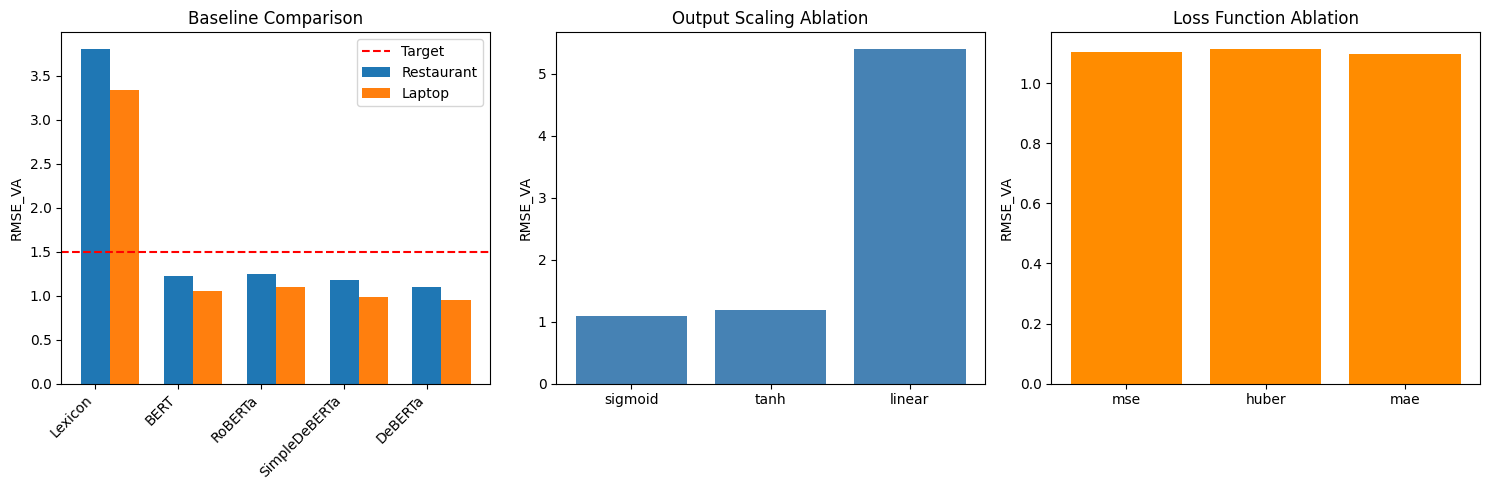

In [ ]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Baseline comparison
ax = axes[0]
models = ['Lexicon-Only', 'BERT-base', 'RoBERTa-base', 'SimpleDeBERTa', 'DeBERTa-DimABSA']
for domain in cfg.domains:
    subset = baseline_df[baseline_df['domain'] == domain]
    rmses = [subset[subset['model'] == m]['rmse_va'].values[0] for m in models]
    ax.bar([i + (0.35 if domain == 'laptop' else 0) for i in range(len(models))],
           rmses, 0.35, label=domain.title())
ax.set_xticks(range(len(models)))
ax.set_xticklabels([m.split('-')[0] for m in models], rotation=45, ha='right')
ax.axhline(1.5, color='red', ls='--', label='Target')
ax.set_ylabel('RMSE_VA')
ax.set_title('Baseline Comparison')
ax.legend()

# 2. Ablation: Output Scaling
ax = axes[1]
scaling_data = ablation_df[ablation_df['ablation'] == 'output_scaling']
ax.bar(scaling_data['variant'], scaling_data['rmse_va'], color='steelblue')
ax.set_ylabel('RMSE_VA')
ax.set_title('Output Scaling Ablation')

# 3. Ablation: Loss Functions
ax = axes[2]
loss_data = ablation_df[ablation_df['ablation'] == 'loss_function']
ax.bar(loss_data['variant'], loss_data['rmse_va'], color='darkorange')
ax.set_ylabel('RMSE_VA')
ax.set_title('Loss Function Ablation')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'results_visualization.png', dpi=150)
plt.show()

## 11. Submission Generation

In [ ]:
def predict_single(model, tokenizer, lexicon, text, aspect, max_len=128):
    """Predict VA for a single text-aspect pair."""
    model.eval()
    enc = tokenizer(text, aspect, truncation=True, padding='max_length',
                    max_length=max_len, return_tensors='pt')

    ids = enc['input_ids'].to(device)
    mask = enc['attention_mask'].to(device)

    # Aspect mask
    if 'token_type_ids' in enc:
        amask = (enc['token_type_ids'] == 1).float().to(device)
    else:
        sep = (ids == tokenizer.sep_token_id).nonzero(as_tuple=True)[1]
        amask = torch.zeros_like(ids, dtype=torch.float)
        if len(sep) >= 2:
            amask[0, sep[0]+1:sep[1]] = 1
        amask = amask.to(device)

    lf = lexicon.extract(text, aspect).unsqueeze(0).to(device) if lexicon else None

    with torch.no_grad():
        out = model(ids, mask, amask, lf)

    return out['valence'].item(), out['arousal'].item()


def generate_submission(model, tokenizer, lexicon, test_data, output_file):
    """Generate submission JSONL file."""
    model.eval()
    predictions = []

    for item in tqdm(test_data, desc="Generating predictions"):
        aspect_vas = []
        for aspect in item['Aspect']:
            v, a = predict_single(model, tokenizer, lexicon, item['Text'], aspect)
            aspect_vas.append({
                'Aspect': aspect,
                'VA': f"{v:.2f}#{a:.2f}"
            })

        predictions.append({
            'ID': item['ID'],
            'Aspect_VA': aspect_vas
        })

    with open(output_file, 'w', encoding='utf-8') as f:
        for pred in predictions:
            f.write(json.dumps(pred) + '\n')

    print(f"Saved {len(predictions)} predictions to {output_file}")
    return predictions

In [ ]:
# Generate submissions for both domains
print("\n" + "="*70)
print("GENERATING SUBMISSIONS")
print("="*70)

# Restaurant
print("\nRestaurant domain:")
restaurant_preds = generate_submission(
    best_model_restaurant, tok_deberta, lexicon,
    data['restaurant']['test'],
    OUTPUT_DIR / 'submissions' / 'submission_restaurant.jsonl'
)

# Laptop
print("\nLaptop domain:")
laptop_preds = generate_submission(
    best_model_laptop, tok_deberta, lexicon,
    data['laptop']['test'],
    OUTPUT_DIR / 'submissions' / 'submission_laptop.jsonl'
)

print("\nSubmission files generated!")


GENERATING SUBMISSIONS

Restaurant domain:


Generating predictions:   0%|          | 0/200 [00:00<?, ?it/s]

Saved 200 predictions to /content/drive/MyDrive/DL_Project/outputs/submissions/submission_restaurant.jsonl

Laptop domain:


Generating predictions:   0%|          | 0/200 [00:00<?, ?it/s]

Saved 200 predictions to /content/drive/MyDrive/DL_Project/outputs/submissions/submission_laptop.jsonl

Submission files generated!


In [ ]:
# Preview submissions
print("\nSample predictions:")
print("\nRestaurant:")
for pred in restaurant_preds[:3]:
    print(f"  {pred['ID']}: {pred['Aspect_VA']}")

print("\nLaptop:")
for pred in laptop_preds[:3]:
    print(f"  {pred['ID']}: {pred['Aspect_VA']}")


Sample predictions:

Restaurant:
  rest26_aspect_va_dev_1: [{'Aspect': 'diner food', 'VA': '7.42#7.49'}, {'Aspect': 'breakfast', 'VA': '7.21#7.27'}]
  rest26_aspect_va_dev_2: [{'Aspect': 'food', 'VA': '8.01#8.07'}, {'Aspect': 'drinks', 'VA': '8.03#8.06'}, {'Aspect': 'service', 'VA': '7.84#7.86'}]
  rest26_aspect_va_dev_3: [{'Aspect': 'burger', 'VA': '7.77#7.91'}, {'Aspect': 'burger places', 'VA': '7.85#7.93'}]

Laptop:
  lap26_aspect_va_dev_1: [{'Aspect': 'touchscreen', 'VA': '6.70#6.72'}]
  lap26_aspect_va_dev_2: [{'Aspect': 'HP', 'VA': '2.47#6.98'}]
  lap26_aspect_va_dev_3: [{'Aspect': 'keyboard', 'VA': '6.50#6.55'}]


## 12. Final Summary

In [ ]:
print("\n" + "="*70)
print("EXPERIMENT SUMMARY")
print("="*70)

print("\n1. BASELINE RESULTS:")
print("-" * 50)
for domain in cfg.domains:
    print(f"\n  {domain.upper()}:")
    subset = baseline_df[baseline_df['domain'] == domain].sort_values('rmse_va')
    for _, row in subset.iterrows():
        status = "PASS" if row['rmse_va'] < 1.5 else "---"
        print(f"    {row['model']:20s}: RMSE={row['rmse_va']:.4f} [{status}]")

print("\n2. BEST MODELS:")
print("-" * 50)
for domain in cfg.domains:
    best = baseline_df[baseline_df['domain'] == domain].sort_values('rmse_va').iloc[0]
    print(f"  {domain.upper()}: {best['model']} (RMSE={best['rmse_va']:.4f})")

print("\n3. ABLATION INSIGHTS:")
print("-" * 50)
for abl_type in ablation_df['ablation'].unique():
    best = ablation_df[ablation_df['ablation'] == abl_type].sort_values('rmse_va').iloc[0]
    print(f"  Best {abl_type}: {best['variant']} (RMSE={best['rmse_va']:.4f})")

print("\n4. FILES GENERATED:")
print("-" * 50)
print(f"  - {OUTPUT_DIR / 'results_baselines.csv'}")
print(f"  - {OUTPUT_DIR / 'results_ablations.csv'}")
print(f"  - {OUTPUT_DIR / 'results_visualization.png'}")
print(f"  - {OUTPUT_DIR / 'submissions' / 'submission_restaurant.jsonl'}")
print(f"  - {OUTPUT_DIR / 'submissions' / 'submission_laptop.jsonl'}")
print(f"  - {OUTPUT_DIR / 'checkpoints' / '*.pt'}")

print("\n" + "="*70)
print("ALL EXPERIMENTS COMPLETE!")
print("="*70)


EXPERIMENT SUMMARY

1. BASELINE RESULTS:
--------------------------------------------------

  RESTAURANT:
    DeBERTa-DimABSA     : RMSE=1.0975 [PASS]
    SimpleDeBERTa       : RMSE=1.1729 [PASS]
    BERT-base           : RMSE=1.2191 [PASS]
    RoBERTa-base        : RMSE=1.2516 [PASS]
    Lexicon-Only        : RMSE=3.8041 [---]

  LAPTOP:
    DeBERTa-DimABSA     : RMSE=0.9556 [PASS]
    SimpleDeBERTa       : RMSE=0.9887 [PASS]
    BERT-base           : RMSE=1.0573 [PASS]
    RoBERTa-base        : RMSE=1.0977 [PASS]
    Lexicon-Only        : RMSE=3.3352 [---]

2. BEST MODELS:
--------------------------------------------------
  RESTAURANT: DeBERTa-DimABSA (RMSE=1.0975)
  LAPTOP: DeBERTa-DimABSA (RMSE=0.9556)

3. ABLATION INSIGHTS:
--------------------------------------------------
  Best output_scaling: sigmoid (RMSE=1.0895)
  Best loss_function: mae (RMSE=1.0957)
  Best learning_rate: 2e-05 (RMSE=1.0898)

4. FILES GENERATED:
--------------------------------------------------
  - /con